Experiment E1-15:
- binary classification
- dataset train 3500, val 1500
- BATCH_SIZE = 20
- IMAGE_SIZE = 384
- EPOCHS = 30
- criterion = nn.BCEWithLogitsLoss()
- optimizer = Adam
- lr=1e-5
- augmentation

model:
- self.base_model(x)
- unfreeze 4 layers
- self.globalavg(x) # (2,2)
- self.flatten(x)
- self.fc(x) # (5120,512)->Relu->Dropout(0.5)->(512,1)

In [1]:
import numpy as np
import os
import sys
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms, models
import torchvision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from PIL import Image

In [2]:
# load common py
sys.path.append('../src')
import config
import common_utils
import data_utils
import train_utils
import plot_utils


In [3]:
# override config for experiment
EXP_CODE = "E1-15"
SAVE_FILENAME = f"stage1-{EXP_CODE}-metrics"

config.EPOCHS = 30
config.LEARNING_RATE = 1e-5
config.IMAGE_SIZE = 384

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

common_utils.set_seed(config.SEED)


In [5]:
df = pd.read_csv(config.TRAIN_CSV)

In [6]:
# split data into train, val, test 70/15/15
# for fast training, use only 3500 and 1500 samples for train and val

train_df, val_df, test_df, train_small_df, val_small_df = data_utils.split_data(df, config.SEED, small_train_size=3500, small_val_size=1500)

In [7]:
# create transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [8]:
# create datasets
train_small_dataset = data_utils.SteelDataset(df=train_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=train_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                    )
val_small_dataset = data_utils.SteelDataset(df=val_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=test_val_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                   )


In [9]:
train_small_loader = DataLoader(train_small_dataset, batch_size=config.BATCH_SIZE,
                          shuffle=True,
                          num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                          )

val_small_loader = DataLoader(val_small_dataset, batch_size=config.BATCH_SIZE,
                         shuffle=False,
                         num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                         )


In [10]:
# create model
class SteelModel(nn.Module):
    def __init__(self):
        super(SteelModel, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1').features
        for param in self.base_model.parameters():
            param.requires_grad = False

        for p in self.base_model[-4:].parameters():
            p.requires_grad = True

        # Remove original classifier
        #self.base_model.classifier = nn.Identity()

        self.globalavg = nn.AdaptiveAvgPool2d((2, 2))

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(1280 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
        )
               

    def forward(self, x):
        x = self.base_model(x)
        #print(x.shape)
        x = self.globalavg(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return x 

In [11]:
model = SteelModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

In [12]:
%%time

arr_train_acc = []
arr_train_loss = []
arr_train_precision = []
arr_train_recall = []
arr_train_f1 = []
arr_train_rocauc = []
arr_train_conf_matrix = []

arr_val_acc = []
arr_val_loss = []
arr_val_precision = []
arr_val_recall = []
arr_val_f1 = []
arr_val_rocauc = []
arr_val_conf_matrix = []

idx = 0
for epoch in range(config.EPOCHS):
    train_loss, train_all_labels, train_all_preds, train_all_probs = train_utils.train_one_epoch(model, train_small_loader, criterion, optimizer, device)
    val_loss, val_all_labels, val_all_preds, val_all_probs = train_utils.validate_one_epoch(model, val_small_loader, criterion, device)

    # train metrics
    train_accuracy = (train_all_preds == train_all_labels).mean()
    train_precision = precision_score(train_all_labels, train_all_preds)
    train_recall = recall_score(train_all_labels, train_all_preds)
    train_f1 = f1_score(train_all_labels, train_all_preds)
    train_rocauc = roc_auc_score(train_all_labels, train_all_probs)
    train_conf_matrix = confusion_matrix(train_all_labels, train_all_preds)
    train_tn, train_fp, train_fn, train_tp = train_conf_matrix.ravel()
    
    arr_train_loss.append(train_loss)
    arr_train_acc.append(train_accuracy)
    arr_train_precision.append(train_precision)
    arr_train_recall.append(train_recall)
    arr_train_f1.append(train_f1)
    arr_train_rocauc.append(train_rocauc)
    arr_train_conf_matrix.append({'tn': train_tn, 'fp': train_fp, 'fn': train_fn, 'tp': train_tp})

    # val metrics
    val_accuracy = (val_all_preds == val_all_labels).mean()
    val_precision = precision_score(val_all_labels, val_all_preds)
    val_recall = recall_score(val_all_labels, val_all_preds)
    val_f1 = f1_score(val_all_labels, val_all_preds)
    val_rocauc = roc_auc_score(val_all_labels, val_all_probs)
    val_conf_matrix = confusion_matrix(val_all_labels, val_all_preds)
    val_tn, val_fp, val_fn, val_tp = val_conf_matrix.ravel()

    arr_val_loss.append(val_loss)
    arr_val_acc.append(val_accuracy)
    arr_val_precision.append(val_precision)
    arr_val_recall.append(val_recall)
    arr_val_f1.append(val_f1)
    arr_val_rocauc.append(val_rocauc)
    arr_val_conf_matrix.append({'tn': val_tn, 'fp': val_fp, 'fn': val_fn, 'tp': val_tp})

    print(idx+1)
    print(f"Epoch {epoch+1}/{config.EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    print(f"  Train Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f} | ROC AUC: {train_rocauc:.4f}")
    print(f"  Train Confusion Matrix: TN={train_tn}, FP={train_fp}, FN={train_fn}, TP={train_tp}")
    print(f"  Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f} | ROC AUC: {val_rocauc:.4f}")
    print(f"  Val Confusion Matrix: TN={val_tn}, FP={val_fp}, FN={val_fn}, TP={val_tp}")

    idx += 1
    #break


1
Epoch 1/30
  Train Loss: 0.5913 | Train Acc: 0.6923
  Val Loss  : 0.4704 | Val Acc: 0.7960
  Train Precision: 0.6727 | Recall: 0.8498 | F1: 0.7510 | ROC AUC: 0.7618
  Train Confusion Matrix: TN=799, FP=790, FN=287, TP=1624
  Val Precision: 0.7803 | Recall: 0.8718 | F1: 0.8235 | ROC AUC: 0.8881
  Val Confusion Matrix: TN=480, FP=201, FN=105, TP=714
2
Epoch 2/30
  Train Loss: 0.4192 | Train Acc: 0.8174
  Val Loss  : 0.3454 | Val Acc: 0.8620
  Train Precision: 0.8115 | Recall: 0.8671 | F1: 0.8384 | ROC AUC: 0.8968
  Train Confusion Matrix: TN=1204, FP=385, FN=254, TP=1657
  Val Precision: 0.8893 | Recall: 0.8535 | F1: 0.8710 | ROC AUC: 0.9368
  Val Confusion Matrix: TN=594, FP=87, FN=120, TP=699
3
Epoch 3/30
  Train Loss: 0.3340 | Train Acc: 0.8543
  Val Loss  : 0.2983 | Val Acc: 0.8760
  Train Precision: 0.8565 | Recall: 0.8807 | F1: 0.8684 | ROC AUC: 0.9335
  Train Confusion Matrix: TN=1307, FP=282, FN=228, TP=1683
  Val Precision: 0.8922 | Recall: 0.8791 | F1: 0.8856 | ROC AUC: 0.948

In [13]:
df_metrics = train_utils.build_metric_df(
    arr_train_loss, arr_train_acc, arr_train_precision, arr_train_recall, 
    arr_train_f1, arr_train_rocauc, arr_train_conf_matrix,
    arr_val_loss, arr_val_acc, arr_val_precision, arr_val_recall, 
    arr_val_f1, arr_val_rocauc, arr_val_conf_matrix
)


In [14]:
df_metrics

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,train_conf_matrix,val_loss,val_acc,val_precision,...,val_rocauc,val_conf_matrix,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
0,0.591323,0.692286,0.672742,0.849817,0.750983,0.761783,"{'tn': 799, 'fp': 790, 'fn': 287, 'tp': 1624}",0.470441,0.796000,0.780328,...,0.888064,"{'tn': 480, 'fp': 201, 'fn': 105, 'tp': 714}",799,790,287,1624,480,201,105,714
1,0.419203,0.817429,0.811459,0.867085,0.838351,0.896783,"{'tn': 1204, 'fp': 385, 'fn': 254, 'tp': 1657}",0.345416,0.862000,0.889313,...,0.936825,"{'tn': 594, 'fp': 87, 'fn': 120, 'tp': 699}",1204,385,254,1657,594,87,120,699
2,0.333957,0.854286,0.856489,0.880691,0.868421,0.933515,"{'tn': 1307, 'fp': 282, 'fn': 228, 'tp': 1683}",0.298319,0.876000,0.892193,...,0.948440,"{'tn': 594, 'fp': 87, 'fn': 99, 'tp': 720}",1307,282,228,1683,594,87,99,720
3,0.302472,0.874000,0.877310,0.894296,0.885722,0.944160,"{'tn': 1350, 'fp': 239, 'fn': 202, 'tp': 1709}",0.276270,0.879333,0.896766,...,0.955065,"{'tn': 598, 'fp': 83, 'fn': 98, 'tp': 721}",1350,239,202,1709,598,83,98,721
4,0.276688,0.880571,0.884992,0.897959,0.891429,0.952751,"{'tn': 1366, 'fp': 223, 'fn': 195, 'tp': 1716}",0.265132,0.883333,0.912821,...,0.958845,"{'tn': 613, 'fp': 68, 'fn': 107, 'tp': 712}",1366,223,195,1716,613,68,107,712
5,0.264750,0.894000,0.898551,0.908425,0.903461,0.956997,"{'tn': 1393, 'fp': 196, 'fn': 175, 'tp': 1736}",0.252188,0.893333,0.897467,...,0.961138,"{'tn': 596, 'fp': 85, 'fn': 75, 'tp': 744}",1393,196,175,1736,596,85,75,744
6,0.231322,0.904286,0.904103,0.922554,0.913235,0.967698,"{'tn': 1402, 'fp': 187, 'fn': 148, 'tp': 1763}",0.255106,0.892667,0.926166,...,0.962606,"{'tn': 624, 'fp': 57, 'fn': 104, 'tp': 715}",1402,187,148,1763,624,57,104,715
7,0.245129,0.898857,0.905258,0.909995,0.907620,0.962924,"{'tn': 1407, 'fp': 182, 'fn': 172, 'tp': 1739}",0.245366,0.901333,0.930680,...,0.964614,"{'tn': 627, 'fp': 54, 'fn': 94, 'tp': 725}",1407,182,172,1739,627,54,94,725
8,0.231197,0.908857,0.917191,0.915751,0.916470,0.967139,"{'tn': 1431, 'fp': 158, 'fn': 161, 'tp': 1750}",0.227063,0.904667,0.910194,...,0.967594,"{'tn': 607, 'fp': 74, 'fn': 69, 'tp': 750}",1431,158,161,1750,607,74,69,750
9,0.218486,0.911143,0.911523,0.927263,0.919326,0.970781,"{'tn': 1417, 'fp': 172, 'fn': 139, 'tp': 1772}",0.222064,0.911333,0.919315,...,0.969256,"{'tn': 615, 'fp': 66, 'fn': 67, 'tp': 752}",1417,172,139,1772,615,66,67,752


In [15]:
print('Val Metrics:')
print(df_metrics[config.VAL_METRICS])
print('')
print('Val Confusion Matrix:')
print(df_metrics[config.VAL_CF])

Val Metrics:
    val_loss   val_acc  val_precision  val_recall    val_f1  val_rocauc
0   0.470441  0.796000       0.780328    0.871795  0.823529    0.888064
1   0.345416  0.862000       0.889313    0.853480  0.871028    0.936825
2   0.298319  0.876000       0.892193    0.879121  0.885609    0.948440
3   0.276270  0.879333       0.896766    0.880342  0.888478    0.955065
4   0.265132  0.883333       0.912821    0.869353  0.890557    0.958845
5   0.252188  0.893333       0.897467    0.908425  0.902913    0.961138
6   0.255106  0.892667       0.926166    0.873016  0.898806    0.962606
7   0.245366  0.901333       0.930680    0.885226  0.907384    0.964614
8   0.227063  0.904667       0.910194    0.915751  0.912964    0.967594
9   0.222064  0.911333       0.919315    0.918193  0.918754    0.969256
10  0.232114  0.901333       0.925222    0.891331  0.907960    0.968023
11  0.218354  0.909333       0.933926    0.897436  0.915318    0.971324
12  0.216609  0.909333       0.892980    0.947497  

In [16]:
df_metrics.describe()

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,val_loss,val_acc,val_precision,val_recall,val_f1,val_rocauc,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.208459,0.913410,0.915904,0.929409,0.922260,0.966659,0.232909,0.906956,0.919401,0.910256,0.914526,0.967037,1420.833333,168.166667,134.900000,1776.100000,614.933333,66.066667,73.500000,745.500000
std,0.100811,0.052668,0.056632,0.028403,0.043133,0.043775,0.056713,0.027473,0.031539,0.025355,0.024058,0.017784,135.354728,135.354728,54.277289,54.277289,29.531904,29.531904,20.765937,20.765937
min,0.112268,0.692286,0.672742,0.849817,0.750983,0.761783,0.192682,0.796000,0.780328,0.853480,0.823529,0.888064,799.000000,71.000000,63.000000,1624.000000,480.000000,35.000000,43.000000,699.000000
25%,0.145428,0.905429,0.906824,0.917452,0.914044,0.967278,0.200824,0.901333,0.911873,0.890415,0.907528,0.965359,1409.500000,104.000000,95.000000,1753.250000,607.250000,52.500000,59.000000,729.250000
50%,0.182452,0.927429,0.931521,0.937206,0.933699,0.979360,0.210973,0.915333,0.927514,0.916361,0.920874,0.973310,1458.000000,131.000000,120.000000,1791.000000,623.000000,58.000000,68.500000,750.500000
75%,0.231291,0.943000,0.945695,0.950288,0.947932,0.987005,0.242053,0.923833,0.934031,0.927961,0.930279,0.976514,1485.000000,179.500000,157.750000,1816.000000,628.500000,73.750000,89.750000,760.000000
max,0.591323,0.961714,0.963002,0.967033,0.965013,0.992230,0.470441,0.930667,0.954188,0.947497,0.935961,0.978280,1518.000000,790.000000,287.000000,1848.000000,646.000000,201.000000,120.000000,776.000000


In [17]:
print(df_metrics.describe())

       train_loss  train_acc  train_precision  train_recall   train_f1  \
count   30.000000  30.000000        30.000000     30.000000  30.000000   
mean     0.208459   0.913410         0.915904      0.929409   0.922260   
std      0.100811   0.052668         0.056632      0.028403   0.043133   
min      0.112268   0.692286         0.672742      0.849817   0.750983   
25%      0.145428   0.905429         0.906824      0.917452   0.914044   
50%      0.182452   0.927429         0.931521      0.937206   0.933699   
75%      0.231291   0.943000         0.945695      0.950288   0.947932   
max      0.591323   0.961714         0.963002      0.967033   0.965013   

       train_rocauc   val_loss    val_acc  val_precision  val_recall  \
count     30.000000  30.000000  30.000000      30.000000   30.000000   
mean       0.966659   0.232909   0.906956       0.919401    0.910256   
std        0.043775   0.056713   0.027473       0.031539    0.025355   
min        0.761783   0.192682   0.796000    

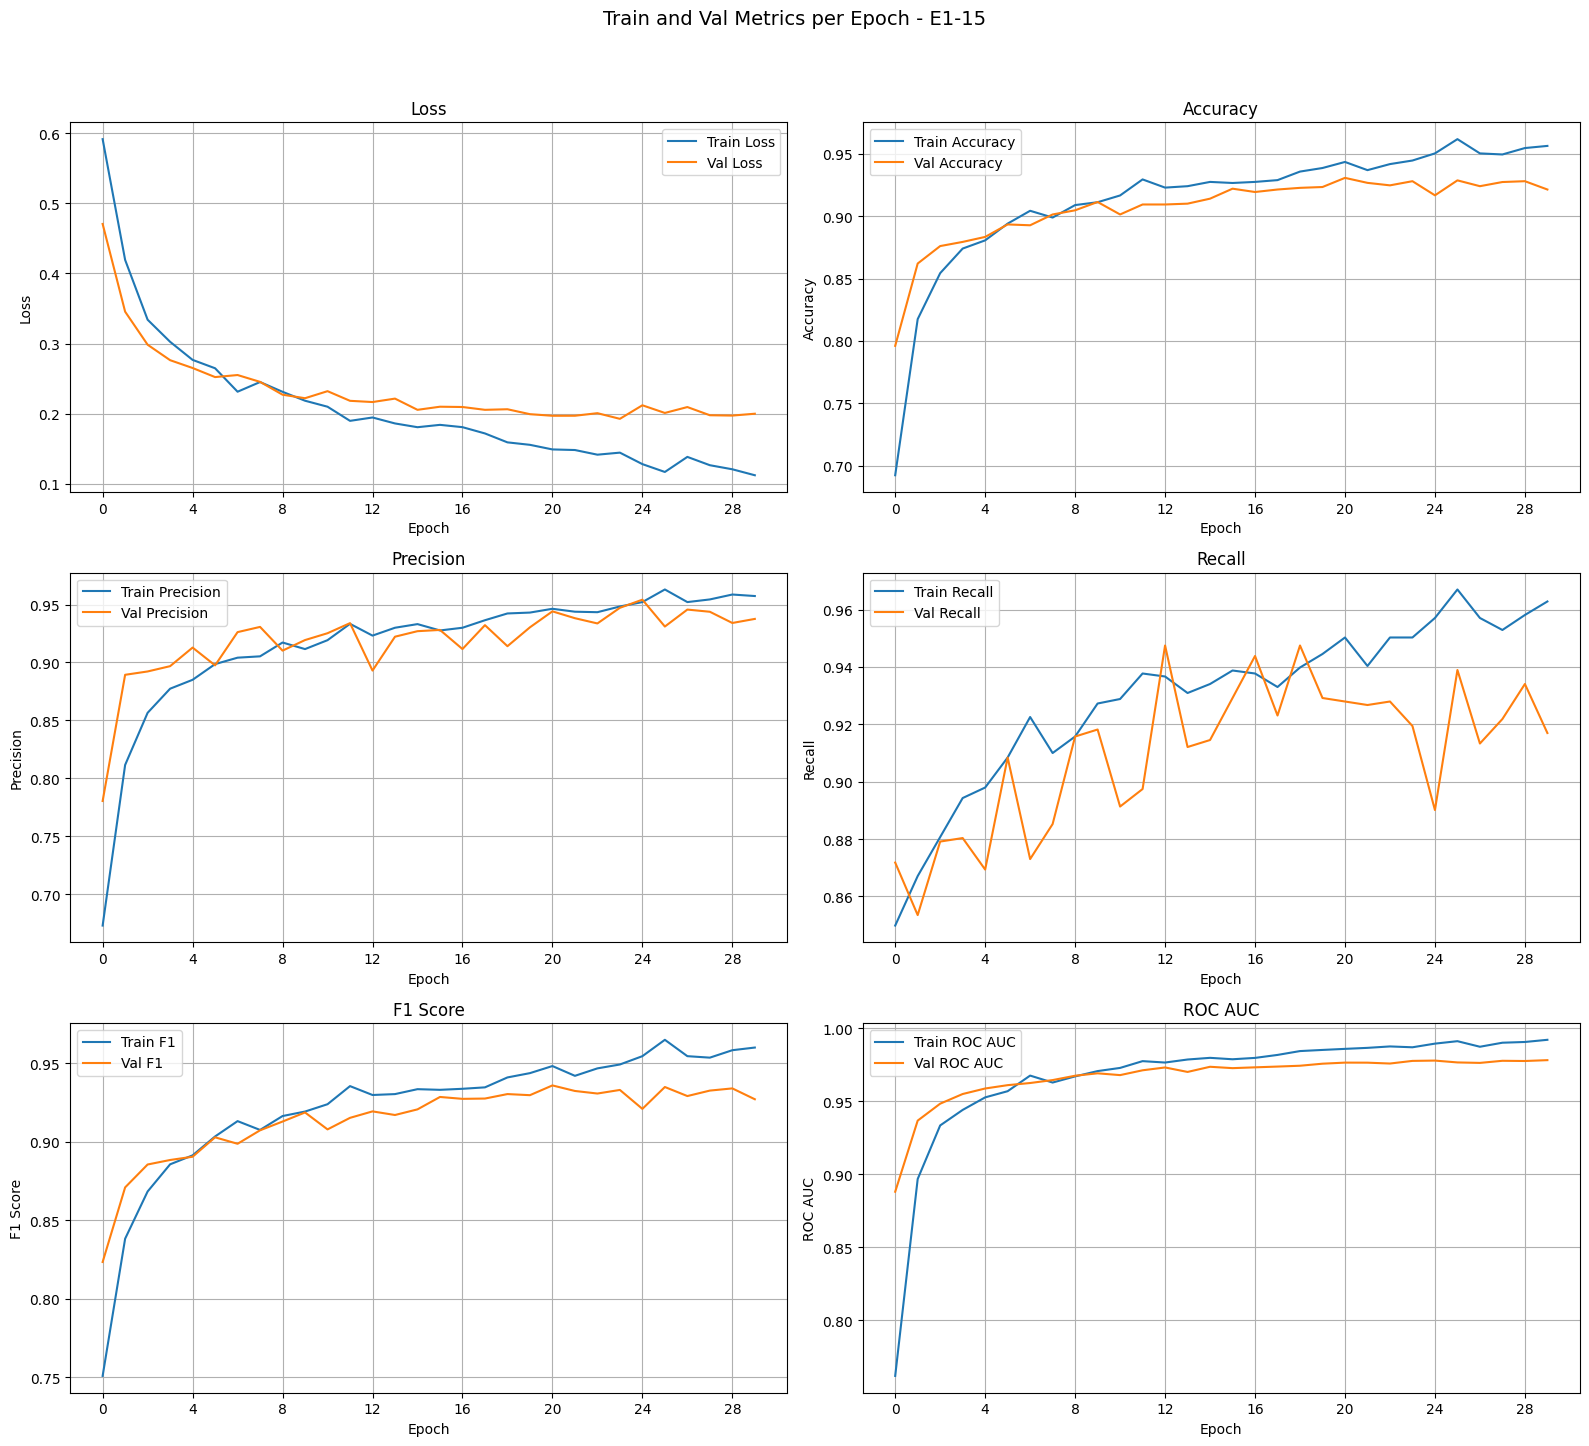

In [18]:
plot_utils.plot_train_val_metrics(df_metrics, exp_code=EXP_CODE, save_path=SAVE_FILENAME+".png")

In [19]:
df_train_conf_matrix = df_metrics['train_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
df_val_conf_matrix = df_metrics['val_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
#df_metrics[['val_tn', 'val_fp', 'val_fn', 'val_tp']]
df_train_conf_matrix.columns = ['train_tn', 'train_fp', 'train_fn', 'train_tp']
df_val_conf_matrix.columns = ['val_tn', 'val_fp', 'val_fn', 'val_tp']



In [20]:
df_train_conf_matrix.describe()

,train_tn,train_fp,train_fn,train_tp
count,30.000000,30.000000,30.000000,30.000000
mean,1420.833333,168.166667,134.900000,1776.100000
std,135.354728,135.354728,54.277289,54.277289
min,799.000000,71.000000,63.000000,1624.000000
25%,1409.500000,104.000000,95.000000,1753.250000
50%,1458.000000,131.000000,120.000000,1791.000000
75%,1485.000000,179.500000,157.750000,1816.000000
max,1518.000000,790.000000,287.000000,1848.000000


In [21]:
df_val_conf_matrix.describe()

,val_tn,val_fp,val_fn,val_tp
count,30.000000,30.000000,30.000000,30.000000
mean,614.933333,66.066667,73.500000,745.500000
std,29.531904,29.531904,20.765937,20.765937
min,480.000000,35.000000,43.000000,699.000000
25%,607.250000,52.500000,59.000000,729.250000
50%,623.000000,58.000000,68.500000,750.500000
75%,628.500000,73.750000,89.750000,760.000000
max,646.000000,201.000000,120.000000,776.000000


In [22]:
df_metrics.to_csv(SAVE_FILENAME+".csv", index=False)